# Two ways for "Human-in-the-Loop" Workflow

1. Nello step di compilazione di una grafo
2. Utilizzando una speciale command class e una interrupt function in combination

Per un human-in-the-loop workflow è necessario fare uso di langGraph persistence layer anche detto checkpointers.

I checkpointers gli abbiamo utilizzati per salvare a chat history, ma ora possiamo fare molto di più con i checkpointers.

Ora, creiamo un semplice agente come abbiamo fatto prima ma ora con human interaction.

In [22]:
from dotenv import load_dotenv

load_dotenv()

True

In [23]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [25]:
# creiamo il nistro grafo
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

checkpointer = MemorySaver()

graph_builder = StateGraph(State)

# definiamo due tools con la stessa descrizione di chiamata

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ['munich']:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

@tool
def broken_api(location: str):
    """Call to get the current weather."""
    return  f"Currently no weather data available for {location}"


tools = [get_weather, broken_api]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [26]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

# la funzione tools_condition importata rrstituisce "tools" se l'ultimo messaggio dello stato
# è un AIMessage con tool_calls esistente altrimenti restituisce END
graph_builder.add_conditional_edges(
    "chatbot", 
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

# ogni volta che dovremmo usare un tool vogliamo interrompere before di usare il tool
# se vogliamo abilitare l'uso di un solo tool con human permission allora usiamo 
# questo interrupt_before

graph = graph_builder.compile(
    checkpointer=checkpointer,  # memorizza gli stati 
    interrupt_before=['tools']  # interrompiamo prima di usare un tool nel nodo "tools"
)

# esiste anche l'alternativa interrupt_after che intterompe il flusso dopo l'eseczione del nodo
# se ad esempio vogliamo controllare il risulatato del nodo tools prima di passarlo
# all'llm allora usiamo interrup_after


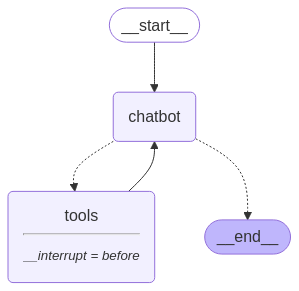

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [28]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Hello, I am John")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='0a52e4bc-93a6-4a7d-b035-57c8439381c9'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc3c54b4-02fe-4630-b9ea-7fbedf44eeab-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [29]:
config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="Sorry, did I already introduce myself?")

graph.invoke({'messages': input_message}, config=config)

{'messages': [HumanMessage(content='Sorry, did I already introduce myself?', additional_kwargs={}, response_metadata={}, id='69d78558-ebd0-4152-9e7c-47c380376196'),
  AIMessage(content="No, you haven't introduced yourself yet. Please feel free to share anything you'd like about yourself!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 73, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-37866cb5-cabe-4663-a416-ec283ee069fb-0', usage_metadata={'input_tokens': 73, 'output_tokens': 21, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [30]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Sorry, did I already introduce myself?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='0a52e4bc-93a6-4a7d-b035-57c8439381c9'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc3c54b4-02fe-4630-b9ea-7fbedf44eeab-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Sorry, did I already introduce myself?', additional_kwargs={}, response_

Fin'ora non abbiamo usato nessun tool poiche non abbiamo chiesto domande riguardanti al tempo.

Quindi come facciamo a sapere effettivamente se dobbiamo usare un tool?

Questo può essere fatto utilizzando dal grafo il metodo .get_state() passandogli il config object.

Così otterremo uno snapshot del grafo.

Tale snapsho ha l'attributo .netx dove possiamo vedere il prossimo step che il grafo dovrebbe chiamare.

Vedimao che ci restituisce una tupla vuota ma perche non abbiamo altro da fare dato che il graph run è finito, ma sarebbe diverso se chiediamo una domanda riguardante il tempo.

In [31]:
snapshot = graph.get_state(config)
snapshot.next

()

In [33]:
# facciamo una domanda riguardante il tempo a monaco
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="How is the waether in Munich?")

# si ferma prima di eseguire il nodo tool
graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the waether in Munich?', additional_kwargs={}, response_metadata={}, id='232b4bcd-19a8-4993-a02f-07e363a18e58'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AjktKeKhnNHvTIaUm4ELMGmh', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 73, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6ce0b083-f293-4d65-9655-6ec1957aa689-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_AjktKeKhnNHvTIaUm4ELMGmh', 'type': 'tool_call'}], usage_metadata={'inpu

In [34]:
# dammi lo stato del thread_id: 3
snapshot = graph.get_state(config)

# qual'è il prossimo step
snapshot.next

('tools',)

Vediamo che il prossimo step è andare nel nodo "tools" quindi il workflow non è ancora terminato.

Ora, come possiamo consentire l'esecuzione del nodo tool.

Questo può essere fatto facilmente eseguendo il grafo una seconda volta, ma stavolta passando None come primo argomento e il config dictionary

In [35]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='How is the waether in Munich?', additional_kwargs={}, response_metadata={}, id='232b4bcd-19a8-4993-a02f-07e363a18e58'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AjktKeKhnNHvTIaUm4ELMGmh', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 73, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6ce0b083-f293-4d65-9655-6ec1957aa689-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_AjktKeKhnNHvTIaUm4ELMGmh', 'type': 'tool_call'}], usage_metadata={'inpu

# Human-in-the-loop Workflow

Fin'ora, ci siamo affidati pienamente su agenti autonomi, dove gli users chiedono una domanda e il sistema indipendentemente genera una risposta ed esegue tasks senza un ulteriore intervento.

Tale approccio funziona bene in molti casi, tuttavia può presentare rischi significativi in scenari dove la posta in gioco è molto alta.

In aree come la conformità, decision making o content creation dove gli errori possono avere serie conseguenze. I sistemi completamente autonomi potrebbero non sempre soddisfare gli standard di affidabilità e precisione.


Human-in-the-loop affronta tale sfida integrando il giudizio umano ad un certo punto cruciale all'interno del processo automatizzato, consentendo le persone di validare, rifinire, o sovrascrivere gli outputs generati dall'AI.

![alt text](human.png)


Questo approccio è particolarmente utile in ambienti dove una automazione non sorvegliata potrebbe condurre a errori molto costosi.

Incorporando momenti di supervisione umana i workflows combinano la velocità e l'efficienza dei processi guidati dalla macchina con una attenta supervisione che solo una persona può fornire.

In pratica, questo spesso significa identificare gli step chiave dove il coinvolgimento umano è più valuable e creare un meccanismo di pausa al flusso automatico per far si che la persona possa rivedere, editare o confermare ciò che il sistema ha prodotto.

Abilitando queste pause per la supervisione umana, human-in-the-loop workflows assicurano che l'automazione sia allineata con le aspettative e riduca la probabilità di errori, se le persone sono coinvolte nell'approvazione di una decisione, rifinendo il contenuto, o fornendo contesto aggiuntivo.


Gli interventi consentono ai sistemi completamente autonomi di funzionare più affidabilmente e meglio in ambienti dove affidabilità e precisione sono essenziali.

# Time Travel

Possiamo non solo stoppare un grafo, ma possiamo anche editarlo.

Per farlo possiamo fare uso del così detto **time-travel**.

Il time-travel ci consente di rifare azioni passate nel nostro grafo per esplorare paths alternativi, come usare tools diversi o solamente editare lo stato.

Prima iniziamo con un semplice esempio dove abbiamo aggiunto lo stato.

In [37]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}

input_message = HumanMessage(content="How is the weather in Munich?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'inpu

In [39]:
snapshot = graph.get_state(config)

# andiamo a estrarre l'ultimo messaggio il quale è
# un AIMessage 
existing_message = snapshot.values["messages"][-1]

# vedimao che il flusso andrebbe a fare uso del tool "get_weather" con argomento
# location = Munich
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_weather (call_sWjOHgpVGB9zJNC8WpRz5CAv)
 Call ID: call_sWjOHgpVGB9zJNC8WpRz5CAv
  Args:
    location: Munich


Vediamo che il flusso andrebbe a fare uso del tool "get_weather" con l'argomento location=Munich. 

Tuttavia, ora noi vogliamo che invece di fare effettivamente ciò lo falsifichiamo dandogli una risposta a mano.

In [40]:
from langchain_core.messages import AIMessage, ToolMessage

answer = "It is only 5°C warm today!"

new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]['id']),
    AIMessage(content=answer),
]

# dopo avre falsificato l'utilizzo del tool aggiungendo in una 
# lista la risposta del Tool e del LLM
# aggiorniamo lo stato passando tale lista
graph.update_state(
    config,
    {"messages": new_messages}
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efff46b-7415-68f0-8002-0cdc7e2eb0db'}}

In [41]:
print((graph.get_state(config).values['messages']))

[HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 

In [42]:
# una volta aggiornato lo stato facciamo una domanda di follow-up
# e ci dovrebbe restiture la risposta "It only 5 C warm today" dato che no deve
# andare nel nodo "tools", ma produce direttamnete una risposta l'llm

config = {"configurable": {"thread_id": "4"}}

input_message = HumanMessage(content="How warm was it again?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'inpu

Abbiamo ottenuto questo senza effettuare effettivamente il tool, ma manipolando noi stessi il flusso inserendo a mano i messagi ToolMessage e AIMessage. E se si domanda ancora quanto è caldo era oggi, l'LLM si basa sulla storia dei messaggi e risponde correttamente.

## Replay

I Checkpoints salvano lo stato del grafo in varie fasi, quindi ci consentono di riavviare il grafo da un punto specifico quando è necessario.

Possiamo ottenere la storia completa degli stati del grafo fornendo il config object e utilizzando il metodo get_state_history()

In [43]:
all_checkpoints = []

for state in graph.get_state_history(config=config):
    all_checkpoints.append(state)

all_checkpoints

[StateSnapshot(values={'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], u

In [57]:
# StateSnapShot con indice più alto (l'ultimo) è il primo stato del grafo cioè quando entra nel grafo
to_replay = all_checkpoints[4]
to_replay.values

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'inpu

In [58]:
# dal checkpoint 4 il prossimo step sarebbe andare nel nodo ToolNode
# che abbiamo simulato aggiungendo i messaggi a mano
to_replay.next

('tools',)

In [ ]:
# la configurazione al checkpoint 4 è:
# vediamo che c'è il checkpoint_id
to_replay.config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efff432-ee61-604e-8001-78d59fd8b9bc'}}

In [60]:
# se chiamamo il grafo da questo punto passando come primo parametro
# None dato che avevamo dato il messaggio all'inizio
# da questo punto è dove si procede poi a chiamare il nodo tool
graph.invoke(None, config=to_replay.config) 

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'inpu

## Branching off past state (diramazione dallo stato passato)

Possiamo utilizzare questo meccanismo per tornare indietro nel tempo (in un checkpoint passato) e soltanto ripartire da un certo punto, ma possiamo anche editare un vecchio stato.

Quindi in questo caso non vogliamo usare il tool "get_weather", ma vogliamo usare un'altro tool.

Dunque, se prendiamo il nostro ultimo messaggio allora possiamo vedere che il tool call che che si userebbe è "get_weather" con argomento location: Munich.

Tuttavia, avevamo creato un'altro tool chiamato "broken_api" con la stessa descrizione del tool "get_weather" ma che restituisce il messaggio "Currently no weather data available for {location}"

Quindi, per fare ciò dobbiamo aggiornare il tool_calls attribute.

In [61]:
# prendiamo lo stato dove l'ultimo messagio è AIMessage con tool_calls 
# con "get_weather"
last_message = to_replay.values['messages'][-1]

In [62]:
last_message.tool_calls

[{'name': 'get_weather',
  'args': {'location': 'Munich'},
  'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv',
  'type': 'tool_call'}]

In [65]:
last_message.tool_calls[0]["name"] = "broken_api"
last_message.tool_calls

[{'name': 'broken_api',
  'args': {'location': 'Munich'},
  'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv',
  'type': 'tool_call'}]

In [66]:
# aggiorniamo il tool_calls attribute per far si che chiami 
# il tool broke_api e non get_weather
branch_config = graph.update_state(
    to_replay.config,
    {"messages": [last_message]}
)

In [67]:
# invochiamo il grafo a partire da questo stato aggiornato
graph.invoke(None, config=branch_config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'input

Vediamo che llm non restitusce una risposta dopo che è stato chiamato il tool "broke_api" quindi fa un'altro tool_call stavolta a "get_weather" il che significa che l'LLM ha identificato un'altro tool che può utilizzare dato che il tool "broke_api" non ha informazioni circa Munich.

Ora andiamo avanti a partire da dove è arrivato lo stato cioè che fa la chiamata al tool "get_weather".

In [68]:
graph.invoke(None, config={"configurable": {"thread_id": "4"}})

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='1890033d-58bb-43c1-8e21-caab2725232d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5916b31b-a351-4d74-be51-8dcbbe54a3b6-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Munich'}, 'id': 'call_sWjOHgpVGB9zJNC8WpRz5CAv', 'type': 'tool_call'}], usage_metadata={'input

# Human expert as ToolNode

## Wait for user input

A volte l'LLM non è in grado di rispondere alla domanda stessa, o non dovrebbe essergli consentito di rispondere alla domanda.

In una conversazione, vogliamo fare affidamento su un esperto umano per un task specifico.

Questo può essere fatto utilizzando una **human note** e interrompendo il flusso prima di utilizzarla.

Poi l'umano esperto risponderà la domanda e potremo continuare con l'esecuzione del grafo.

Per determinare se dobbiamo chiedere all'esperto umano o no faremo uso del tool_calling in combinazione con un boolean flag nel nostro state object.  

In [69]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool




In [70]:
from langchain_core.tools import tool

@tool 
def request_assistance():
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires suppoort beyond your permission.
    
    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    return "" # non restituiamo niente dato che l'esperto deve rispondere

In [71]:
tools = [get_weather]

llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools + [request_assistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    ask_human = False
    if response.tool_calls and response.tool_calls[0]['name'] == "request_assistance":
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [ ]:
# ora creiamo il nostro grafo 
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools)) # al nodo ToolNode passo solo il tool "get_weather" no "request_assistance"



In [73]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response, 
        tool_call_id=ai_message.tool_calls[0]['id']
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state['messages'][-1], ToolMessage):
        new_messages.append(
            create_response("Plan your trip 3 months before and you don't carry a Real Madrid shirt with you", 
            state['messages'][-1])
        )
    return {
        "messages": new_messages, 
        "ask_human": False
    }

graph_builder.add_node("human", human_node)

In [74]:
# archi condizionali

def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state) # nodo "tools" o nodo END

graph_builder.add_conditional_edges(
    "chatbot", 
    select_next_node,
    path_map={"human": "human", "tools": "tools", "__end__": "__end__"} 
)


In [75]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")

graph_builder.set_entry_point("chatbot")

checkpointer = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["human"]
)

In [76]:
config = {"configurable": {"thread_id": "50"}}

input_message = HumanMessage(
    content="I need some expert advice on how to plan a trip to barcelona"
)

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='7a757faa-2ee7-45ea-b0f9-7e55f8aa59aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mLZt9DcuxUmsmsuBP71TWsyY', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 117, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e55c1867-c5d6-407f-82bb-f1d9887ff114-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_mLZt9DcuxUmsmsuBP71TWsyY', 'type': 'tool_call'}], usage_metadat

In [77]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='7a757faa-2ee7-45ea-b0f9-7e55f8aa59aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mLZt9DcuxUmsmsuBP71TWsyY', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 117, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e55c1867-c5d6-407f-82bb-f1d9887ff114-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_mLZt9DcuxUmsmsuBP71TWsyY', 'type': 'tool_call'}], usage_metadat

# Command Class

Nella versione 0.257 LangGraph ha introdotto la "command class" e la interrupt function come un nuovo modo per implementare human-in-the-loop workflows.

Possiamo ancora usare l'interrupt parameter nello step di compilazione (.compile()) e LangGraph non farà apparire che è deprercato.

Vediamo alcuni benefici della Command Class.

La Command Class ci abilita a creare graph senza archi (edgeless), semplificando workflows consentendo transizioni più flessibili tra i nodi.

Ecco come funziona:

Definiamo una funzione, ma invece di restituire lo stato direttamente, restituiamo una istanza della classe command.

Il costruttore di Command prende 2 parametri chiave:

1. goto: specifica il prossimo nodo da eseguire 
2. update: aggiorna lo stato, il quale rimpiazza il valore che tipicamente restituiamo da un nodo. In altre parole, aggiorna lo stato per il nodo successivo (il quale è stato impostato in "goto")


### New way Human in the loop: Interrupt + Command

In [2]:
from typing import  TypedDict, Literal
from langgraph.graph import START, END, StateGraph
from langgraph.types import Command

class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state(input_state: InputState):
    input_state["string_value"] += "a"
    input_state["numeric_value"] += 1

    return input_state


def branch_a(state: InputState):
    print(f"branch_a: Current state: {state}")

    new_state = modify_state(state)

    print(f"branch_a: Updated state: {new_state}")

    return Command(
        goto="branch_b",
        update=new_state
    )


def branch_b(state: InputState):
    print(f"branch_b: Current State: {state}")

    new_state = modify_state(state)

    print(f"branch_b: Updated state: {new_state}")

    return Command(
        goto="branch_c",
        update=new_state
    )


def branch_c(state: InputState):
    print(f"branch_c: Current State: {state}")
    new_state = modify_state(state)
    print(f"branch_c: Updated state: {new_state}")

    return Command(
        goto=END,
        update=new_state
    )

In [3]:
# ora possiamo creare il grafo edgeless

graph = StateGraph(InputState)

graph.add_node("branch_a", branch_a)
graph.add_node("branch_b", branch_b)
graph.add_node("branch_c", branch_c)
graph.set_entry_point("branch_a")

runnable = graph.compile()

In [5]:
initial_state = {
    "string_value": "Hello",
    "numeric_value": 0
}

final_state = runnable.invoke(initial_state)

print("Final state:", final_state)

branch_a: Current state: {'string_value': 'Hello', 'numeric_value': 0}
branch_a: Updated state: {'string_value': 'Helloa', 'numeric_value': 1}
branch_b: Current State: {'string_value': 'Helloa', 'numeric_value': 1}
branch_b: Updated state: {'string_value': 'Helloaa', 'numeric_value': 2}
branch_c: Current State: {'string_value': 'Helloaa', 'numeric_value': 2}
branch_c: Updated state: {'string_value': 'Helloaaa', 'numeric_value': 3}
Final state: {'string_value': 'Helloaaa', 'numeric_value': 3}


Ora implementiamo un Human in the loop workflow con interrupt function e command.

Vedremo la funzione interrupt e come interagisce con Command.

Interrupt è responsabile di stoppare il nodo che stiamo correntemente eseguendo.

Nello step di interrupt l'utente vedrà che i dati che definiamo dentro la funzione interrupt.

Memorizziamo il risultato della funzione interrupt dentro una nuova variabile chiamata human_review. 

Poi vedimao che ci sono due linee dove estraiamo le chiavi "action" e "data".

Poi vediamo che ci sono delle codizioni in base a se il valore delle chiave "action" è "update" o "continue.

Ma dov'è che abbiamo effettivamente passato tali valori?

Per questo necessitiamo della Command Class. Quando invokiamo il grafo passiamo in input una istanza di Command con uno dei suddetti valori ad es. Command(resume={"action": "continue"})

Dunque la funzione interrupt utilizza i valori di Command passati nell'invocazione del grafo, estrae tali valori e determina la next action.

In [18]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """Search for the weather in a specific city."""

    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"

model = ChatOpenAI(model="gpt-4o").bind_tools([weather_search])

def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal['call_llm', 'run_tool']]:
    last_message = state['messages'][-1]

    # dato che sappiamo che finiamo qui quando si fa una tool calling
    # possiamo accedervi agli attributi del tool calling
    tool_call = last_message.tool_calls[-1]

    # funzione di interrupt
    # come si deve comportare il workflow a questo punto
    human_review = interrupt(
        {
            "question": "Is this correct?",
            "tool_call": tool_call
        }
    )

    print("Human review values:", human_review)

    review_action = human_review['action']

    review_data = human_review.get('data')

    # nel caso che dopo l'interruzione poi rieseguiamo il grafo
    # passando in Command action = "continue"
    if review_action == "continue":
        return Command(goto="run_tool")

    # se vogliamo invece aggiornare lo stato con il feedback umano
    # dobbiamo passare in Command, quando avviamo il grafo, sia i dati e l'azione 
    # "update"
    if review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call['id'],
                    "name": tool_call['name'],
                    "args": review_data
                }
            ],
            "id": last_message.id
        }

        return Command(goto="run_tool", update={"messages": [updated_message]})


# arco condizionale 
def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state['messages'][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(MessagesState)

builder.add_node("call_llm", call_llm)
builder.add_node("run_tool", ToolNode(tools=[weather_search]))
builder.add_node("human_review_node", human_review_node)

builder.add_conditional_edges(
    "call_llm",
    route_after_llm
)

builder.add_edge("run_tool", "call_llm")

builder.set_entry_point("call_llm")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)


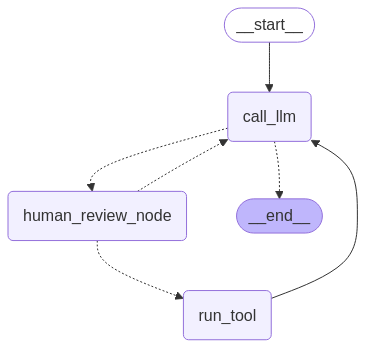

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langchain_core.messages import HumanMessage
initial_input = {"messages": [HumanMessage(content="How is the weather in Munich?")]}

config = {"configurable": {"thread_id": "5"}}

first_result = graph.invoke(input=initial_input, config=config, stream_mode="updates")
first_result

[{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GotH1qQLX3RyLRyFnRFklpmi', 'function': {'arguments': '{"city":"Munich"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 53, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_8adc83c802', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eb94e241-1f27-46f5-985f-e56da20a39d9-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munich'}, 'id': 'call_GotH1qQLX3RyLRyFnRFklpmi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 16, 'total_tokens': 69, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details'

In [21]:
print(graph.get_state(config).next)

('human_review_node',)


In [22]:
# riprendiamo il flusso decidendo se continuare con la chiamta al tool
# e con gli argomenti decisi dal modello o se aggiornare l'AIMessage con
# i nostri argomenti 
graph.invoke(Command(resume={"action": "continue"}), config=config)

Human review values: {'action': 'continue'}
----
Searching for: Munich
----


{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='aa3c64a3-0ec5-4b63-9550-3514bba8411a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GotH1qQLX3RyLRyFnRFklpmi', 'function': {'arguments': '{"city":"Munich"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 53, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_8adc83c802', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eb94e241-1f27-46f5-985f-e56da20a39d9-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munich'}, 'id': 'call_GotH1qQLX3RyLRyFnRFklpmi', 'type': 'tool_call'}], usage_metadata={'input_

In [23]:
initial_input = {"messages": [HumanMessage(content="How is the weather in Paris?")]}
config = {"configurable": {"thread_id": "6"}}

graph.invoke(initial_input, config=config, stream_mode="updates")

[{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MhJQVcbRcNuUYCvcEByOTSEv', 'function': {'arguments': '{"city":"Paris"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 53, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_8adc83c802', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d6af30db-9469-459d-ac30-516db98d9927-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Paris'}, 'id': 'call_MhJQVcbRcNuUYCvcEByOTSEv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 15, 'total_tokens': 68, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 

In [14]:
print(graph.get_state(config).next)

('human_review_node',)


In [24]:
# riprendiamo il flusso ma stavolta con un nuovo argomento
# voluto dallo human che la chiamata del tool weather_search

graph.invoke(Command(resume={"action": "update", "data": {"city": "Paris"}}), config=config)

Human review values: {'action': 'update', 'data': {'city': 'Paris'}}
----
Searching for: Paris
----


{'messages': [HumanMessage(content='How is the weather in Paris?', additional_kwargs={}, response_metadata={}, id='3565f464-72f7-4493-a581-357a27bdd0d3'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-d6af30db-9469-459d-ac30-516db98d9927-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Paris'}, 'id': 'call_MhJQVcbRcNuUYCvcEByOTSEv', 'type': 'tool_call'}]),
  ToolMessage(content='Sunny!', name='weather_search', id='cd019357-1772-4a92-939e-7ca6a355a958', tool_call_id='call_MhJQVcbRcNuUYCvcEByOTSEv'),
  AIMessage(content='The weather in Paris is currently sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 77, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fin